# Titanic Survival with XGBoost

**Historical Overview:**

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

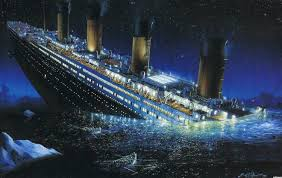

**Goal:**

we neeedto build a predictive model that answers the questions: what sorts of people were more likely to survive? where some features and charactaristics contributed in people survival?

**Data:** 

using passenger data:  name, age, gendersocio-economic class,
parents/children/sibling etc.

the link to the dataset on kaggle:

https://www.kaggle.com/competitions/titanic/data?select=test.csv


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

### Load Data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudfahmy77","key":"1ee2e27a2b59626e763a61e3eaef23c1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 21.4MB/s]


In [ ]:
! mkdir titanic_data
! unzip titanic.zip -d titanic_data

Archive:  titanic.zip
  inflating: titanic_data/gender_submission.csv  
  inflating: titanic_data/test.csv   
  inflating: titanic_data/train.csv  


In [ ]:
training_data=pd.read_csv("/content/titanic_data/train.csv")
training_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
training_data.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


* From the first look we can exclude the columns:"Id", "Name" they have no effect

* Investigating the cabin column:

In [ ]:
training_data.Cabin[training_data.Survived==1].value_counts()* 100/len(training_data)

B96 B98    0.448934
E101       0.336700
F33        0.336700
B18        0.224467
B20        0.224467
             ...   
C32        0.112233
E34        0.112233
C7         0.112233
C54        0.112233
C148       0.112233
Name: Cabin, Length: 101, dtype: float64

In [ ]:
training_data.Cabin[training_data.Survived==0].value_counts()* 100/len(training_data)

G6             0.224467
C22 C26        0.224467
C23 C25 C27    0.224467
F G73          0.224467
D26            0.224467
                 ...   
C91            0.112233
C2             0.112233
T              0.112233
C128           0.112233
B51 B53 B55    0.112233
Name: Cabin, Length: 62, dtype: float64

There is no significance difference between the Cabin, So we will exclude it as well

* Investigating the Ticket column:

In [ ]:
training_data.Ticket[training_data.Survived==1].value_counts()* 100/len(training_data)

1601      0.561167
2666      0.448934
113760    0.448934
13502     0.336700
347077    0.336700
            ...   
244367    0.112233
234818    0.112233
28551     0.112233
7598      0.112233
111369    0.112233
Name: Ticket, Length: 260, dtype: float64

In [ ]:
training_data.Ticket[training_data.Survived==0].value_counts()* 100/len(training_data)* 100/len(training_data)

347082           0.088174
CA. 2343         0.088174
347088           0.075578
3101295          0.075578
CA 2144          0.075578
                   ...   
349233           0.012596
349236           0.012596
SC/Paris 2163    0.012596
349206           0.012596
370376           0.012596
Name: Ticket, Length: 470, dtype: float64

There is no significance difference between the Tickets, So we will exclude it as well

* Dropping the excluded columns

In [ ]:
training_data=training_data.drop(columns=["PassengerId","Name","Cabin","Ticket"])
training_data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


* Handling Missing Values

We've got missing values in 2 columns: "Age" & "Embarked"

1."Age" column: 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


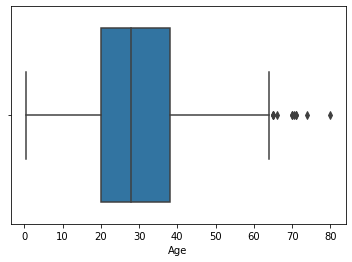

In [ ]:
sns.boxplot(training_data["Age"])

Since we have outliers, we will use the median for imputation

In [ ]:
training_data["Age"]=training_data["Age"].fillna(training_data["Age"].median())

2."Embarked" column
we will use the most frequent port "S"

In [ ]:
training_data["Embarked"]=training_data["Embarked"].fillna("S")

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


* Data distribution

Text(0.5, 0.98, 'features distribution')

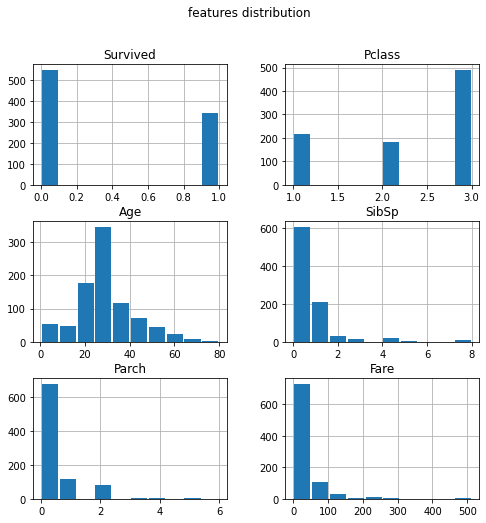

In [ ]:
training_data.hist(zorder=2, rwidth=0.9,figsize=(8,8))
plt.suptitle("features distribution")

* Correlation

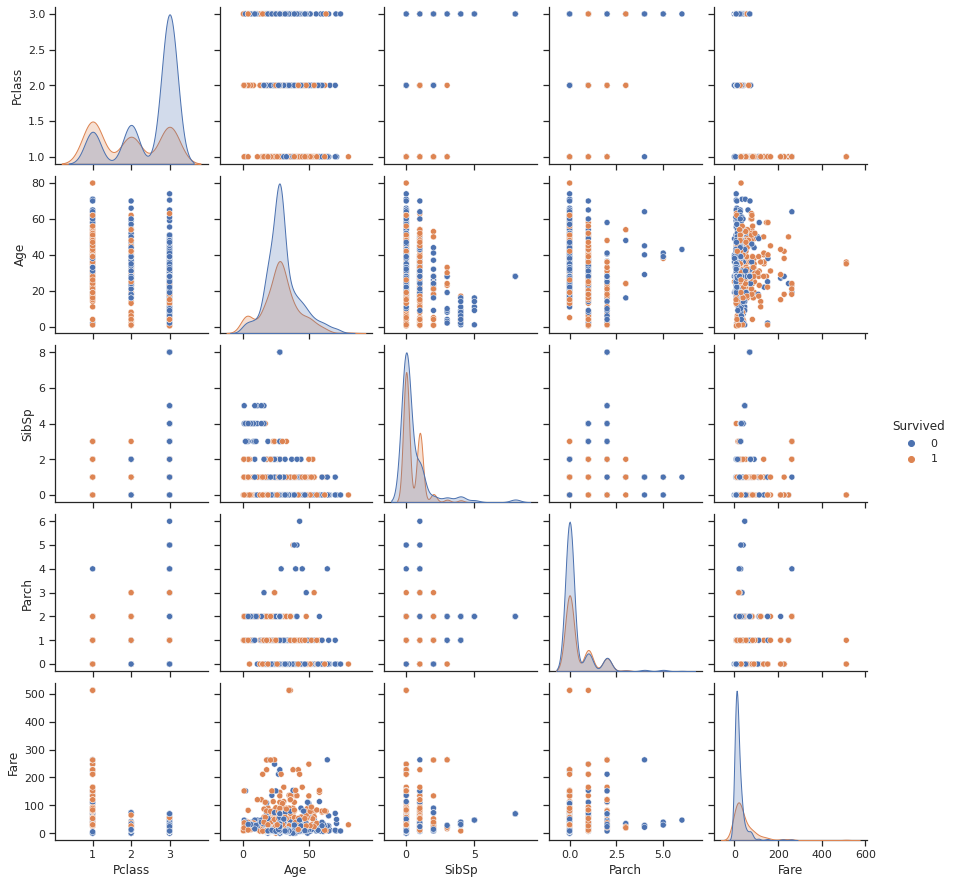

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(training_data, hue="Survived")

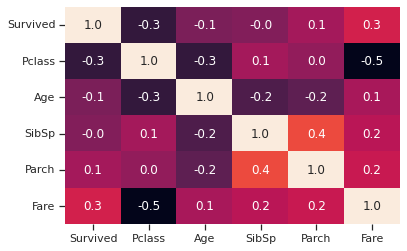

In [ ]:
corr=training_data.corr()
sns.heatmap(corr, annot=True, fmt='.1f', cbar=False)

In [ ]:
corr["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Pclass     -0.338481
Name: Survived, dtype: float64

### Data Preparation

* Performing one-hot encoding on the categorical variable

In [ ]:
training_data=pd.get_dummies(data=training_data, columns=['Pclass', 'Sex','Embarked'])
training_data.head(5)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [ ]:
x_train=training_data.drop(columns=["Survived"])
y_train=training_data["Survived"]

In [ ]:
x_train.shape,y_train.shape

((891, 12), (891,))

#### Applying the same data cleaning and preparation on the testing set

In [ ]:
testing_data=pd.read_csv("/content/titanic_data/test.csv")
testing_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
testing_data=testing_data.drop(columns=["PassengerId","Name","Ticket","Cabin"])
testing_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [ ]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [ ]:
testing_data["Age"]=testing_data["Age"].fillna(training_data["Age"].median())
testing_data["Fare"]=testing_data["Fare"].fillna(training_data["Fare"].mean())

In [ ]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [ ]:
testing_data=pd.get_dummies(data=testing_data, columns=['Pclass', 'Sex','Embarked'])
testing_data.head(5)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


In [ ]:
x_test=testing_data
x_test.shape

(418, 12)

### Building The Model

In [ ]:
model=XGBClassifier(learning_rate=0.01)

### Fitting The Model

In [ ]:
model.fit(x_train,y_train)

XGBClassifier(learning_rate=0.01)

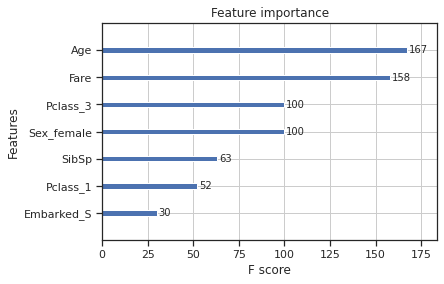

In [ ]:
xgb.plot_importance(model,ax=plt.gca())

### Model Performance on the training set

In [ ]:
model.score(x_train,y_train)

0.8316498316498316

In [ ]:
y_pred=model.predict(x_train)
cnf_matrix = metrics.confusion_matrix(y_train, y_pred)
cnf_matrix

array([[492,  57],
       [ 93, 249]])

Text(0.5, 257.44, 'Predicted label')

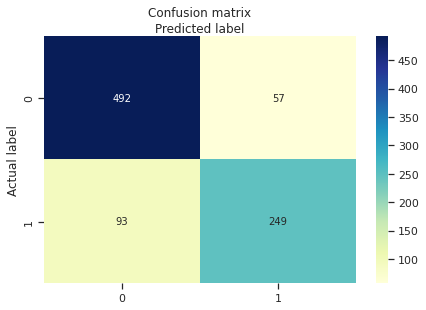

In [ ]:
class_names = [0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Making Predictions

In [ ]:
prediction = model.predict(x_test)  # prediction

print(f" predicting a digit: \n{prediction[:10]}")


 predicting a digit: 
[0 1 0 0 1 0 1 0 1 0]


### Preparing the submission file

In [ ]:
sub=pd.read_csv("/content/titanic_data/gender_submission.csv")
Id=sub["PassengerId"].to_numpy()
submission=pd.DataFrame({"PassengerId":Id,"Survived":prediction})
submission.to_csv("submission.csv")
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
